# Project Overview

Our client, a grocery retailer, sent out mailers in a marketing campaign for their new delivery club. This cost customers 100 dollar per year for membership, and offered free grocery deliveries, rather than the normal cost of 10 dollar per delivery.

For this, they sent mailers to their entire customer base (apart from a control group) but this proved expensive. For the next batch of communications they would like to save costs by only mailing customers that were likely to sign up.

Based upon the results of the last campaign and the customer data available, we will look to understand the probability of customers signing up for the delivery club. This would allow the client to mail a more targeted selection of customers, lowering costs, and improving ROI.

Let’s use Machine Learning to take on this task!


# Logistic Regression

We utlise the scikit-learn library within Python to model our data using Logistic Regression. The code sections below are broken up into 5 key sections:

* Data Import
* Data Preprocessing
* Model Training
* Performance Assessment
* Optimal Threshold Analysis

In [64]:
# Logistic regression is a model used to predict the probabilities of a certain
# class or event based on one or more input variables

# it transforms linear relationships to a probabilistic output through the logistic
# function.
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
data_for_model = pickle.load(open('/Users/praju/Desktop/DSI/Untitled Folder/ETA/abc_classification_modelling.p', "rb"))

In [66]:
data_for_model.head()

,customer_id,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,1,3.38,F,0.59,1586.89,195,26,5,61.034231
1,524,1,4.76,F,0.52,2397.26,258,27,5,88.787407
2,607,1,4.45,F,0.49,1279.91,183,22,5,58.177727
3,343,0,0.91,M,0.54,967.14,102,17,5,56.890588
4,322,1,3.02,F,0.63,1566.35,182,30,5,52.211667


In [67]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 860 entries, 0 to 859
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           860 non-null    int64  
 1   signup_flag           860 non-null    int64  
 2   distance_from_store   855 non-null    float64
 3   gender                855 non-null    object 
 4   credit_score          852 non-null    float64
 5   total_sales           860 non-null    float64
 6   total_items           860 non-null    int64  
 7   transaction_count     860 non-null    int64  
 8   product_area_count    860 non-null    int64  
 9   average_basket_value  860 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 73.9+ KB


In [68]:
data_for_model.drop('customer_id',axis=1,inplace=True)

In [69]:
data_for_model.shape

(860, 9)

In [70]:
# Shuffle Data

# if there are unknown order in data i.e sorted by customer number i.e sorted in longer term customer 
# to newer customers, this may or may not have the impact on the model and easy way to make sure it does'nt is to 
# always shuffle our data

data_for_model = shuffle(data_for_model, random_state=42)

In [71]:
data_for_model.head()

,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
714,0,1.64,M,0.58,27.81,6,3,3,9.270000
605,0,0.88,M,0.63,26.62,9,3,2,8.873333
120,0,0.56,M,0.62,886.78,154,18,4,49.265556
208,0,0.11,M,0.58,1256.19,168,34,5,36.946765
380,0,1.32,M,0.36,739.67,110,21,3,35.222381


In [72]:
data_for_model['signup_flag'].value_counts(normalize=True)
# Returns percentage or proportions of zero and 1

# its not perfectly balance but also not too imbalanced
# its good to see how the model performs well in this data

0    0.689535
1    0.310465
Name: signup_flag, dtype: float64

We see that **69%** of customers did not sign up and 31% did. This tells us that while the data isn’t perfectly balanced at 50:50, it isn’t too imbalanced either. Because of this, and as you will see, we make sure to not rely on classification accuracy alone when assessing results - also analysing Precision, Recall, and F1-Score.

## Missing Values

In [73]:
data_for_model.isna().sum()

signup_flag             0
distance_from_store     5
gender                  5
credit_score            8
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [74]:
data_for_model.shape

(860, 9)

In [75]:
data_for_model.dropna(how='any', inplace=True)

In [76]:
data_for_model.isna().sum()

signup_flag             0
distance_from_store     0
gender                  0
credit_score            0
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [77]:
data_for_model.isna().shape

(847, 9)

In [78]:
data_for_model.describe()

,signup_flag,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000
mean,0.304604,2.614545,0.597521,968.166411,143.877214,22.214876,4.177096,38.034161
std,0.460512,14.397590,0.102264,1073.647531,125.342694,11.721699,0.920887,24.243691
min,0.000000,0.000000,0.260000,2.090000,1.000000,1.000000,1.000000,2.090000
25%,0.000000,0.730000,0.530000,383.940000,77.000000,16.000000,4.000000,21.734700
50%,0.000000,1.640000,0.590000,691.640000,123.000000,23.000000,4.000000,31.069333
75%,1.000000,2.920000,0.670000,1121.530000,170.500000,28.000000,5.000000,46.429973
max,1.000000,400.970000,0.880000,7372.060000,910.000000,75.000000,5.000000,141.054091



Based on this investigation, we see some max column values for several variables to be much higher than the median value.

This is for columns distance_from_store, total_sales, and total_items

For example, the median distance_to_store is 1.64 miles, but the maximum is over 400 miles!

Because of this, we apply some outlier removal in order to facilitate generalisation across the full dataset.

We do this using the “boxplot approach” where we remove any rows where the values within those columns are outside of the interquartile range multiplied by 2.

## Outliers

In [79]:

outlier_columns = ['distance_from_store','total_sales','total_items']

for col in outlier_columns:
    lower_quartile = data_for_model[col].quantile(0.25)
    upper_quartile = data_for_model[col].quantile(0.75)
    iqr = upper_quartile - lower_quartile
    iqr_extended = iqr*2 # here i keep 2 instead of 1.5 , as i said i don't want to cut too many
    # outliers as it is worth investigating this lot more than what we done here
    # and i just don't wanna make naive assumption that there are outliers in our data
    # but i want to include the logic so we can see in action
    min_border = lower_quartile - iqr_extended
    max_border = upper_quartile + iqr_extended
    
    outliers = data_for_model[(data_for_model[col] < min_border)| (data_for_model[col] > max_border)].index
    
    outliers1 = data_for_model[(data_for_model[col] < min_border)| (data_for_model[col] > max_border)]
    
    print(f'{len(outliers)} outliers detected in column {col}')
    
    data_for_model.drop(outliers,inplace=True)

8 outliers detected in column distance_from_store
54 outliers detected in column total_sales
3 outliers detected in column total_items


**Split Out Data For Modelling**

In the next code block we do two things, we firstly split our data into an X object which contains only the predictor variables, and a y object that contains only our dependent variable.

Once we have done this, we split our data into training and test sets to ensure we can fairly validate the accuracy of the predictions on data that was not used in training. In this case, we have allocated 80% of the data for training, and the remaining 20% for validation. We make sure to add in the stratify parameter to ensure that both our training and test sets have the same proportion of customers who did, and did not, sign up for the delivery club - meaning we can be more confident in our assessment of predictive performance.

In [80]:
data_for_model.shape

(782, 9)

In [81]:
# splitting input & output variable

X = data_for_model.drop('signup_flag',axis=1)
y = data_for_model['signup_flag']

In [82]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)
# stratify = means our train and test set should have same proportions of classes as overall data

In [83]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(625, 8)
(157, 8)
(625,)
(157,)


## Categorical Predictor Variables

In [85]:
# deal with categorical input variable

categorical_vars = ["gender"]

one_hot_encoder = OneHotEncoder(sparse=False,drop='first') # sparse = False means
# it will return an array rather than a sparse matrix
# meaning array will be easier to visualize
# remove dummy variable for multicollinearity by using drop = first

X_train_encoded=one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded=one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded,columns=encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True),X_train_encoded.reset_index(drop=True)],axis=1)
X_train.drop(categorical_vars,axis=1,inplace=True)

X_test_encoded = pd.DataFrame(X_test_encoded,columns=encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True),X_test_encoded.reset_index(drop=True)],axis=1)
X_test.drop(categorical_vars,axis=1,inplace=True)


/Users/praju/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [86]:
X_train.head()

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,0.07,0.57,746.15,133,24,5,31.089583,1.0
1,0.20,0.57,585.46,128,32,4,18.295625,1.0
2,3.07,0.53,1151.24,226,35,5,32.892571,0.0
3,2.86,0.77,14.03,8,2,2,7.015000,0.0
4,0.52,0.52,656.48,121,16,3,41.030000,1.0


## Feature Selection

In [87]:
clf = LogisticRegression(random_state=42, max_iter = 1000)
# max_iter = number of iterations that model takes to try and find the optimal regression line 
feature_selector = RFECV(clf)

fit = feature_selector.fit(X_train,y_train)

optimal_feature_count = feature_selector.n_features_
print(f"optimal number of features: {optimal_feature_count}")


optimal number of features: 7


In [94]:

X_train = X_train.loc[:,feature_selector.get_support()]
X_test = X_test.loc[:,feature_selector.get_support()]

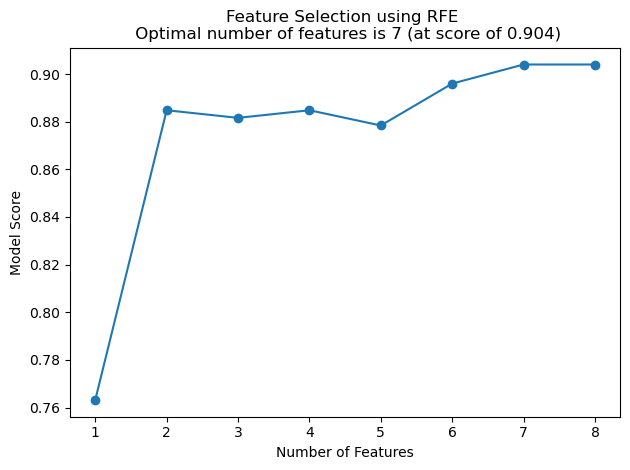

In [96]:


plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), fit.cv_results_['mean_test_score'], marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.cv_results_['mean_test_score']),4)})")
plt.tight_layout()
plt.show()

## Model Training

In [97]:
clf = LogisticRegression(random_state=42, max_iter = 1000)
clf.fit(X_train,y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [98]:
y_pred_class = clf.predict(X_test)


In [99]:
y_pred_prob = clf.predict_proba(X_test)[:,1] # prob that they signed for delivery club

In [100]:
y_pred_prob

array([9.96910185e-03, 1.66728555e-01, 7.79034323e-01, 5.13061997e-02,
       4.88615611e-03, 9.31770546e-01, 2.85253931e-05, 4.77141756e-02,
       9.27429731e-06, 1.63652647e-04, 4.04115399e-02, 1.36528728e-02,
       2.89950276e-03, 5.65721977e-02, 1.25170200e-02, 4.32276730e-01,
       1.05406149e-02, 3.76888655e-04, 7.14343340e-03, 6.14594287e-02,
       6.12773944e-01, 7.46920907e-01, 7.46731345e-01, 5.88924393e-01,
       8.59058829e-04, 2.35988396e-03, 6.04020390e-03, 3.07483586e-01,
       1.52522053e-01, 1.33624295e-01, 8.33460492e-01, 9.99452714e-01,
       2.37849439e-01, 1.63854827e-02, 9.49676380e-02, 4.78407780e-05,
       9.84235117e-01, 1.36933355e-01, 1.54187865e-04, 6.26100757e-01,
       6.59814584e-04, 9.03960776e-03, 1.80303996e-02, 3.77274726e-01,
       1.91955367e-02, 2.20833743e-02, 8.56178241e-01, 2.09221493e-02,
       3.56285195e-02, 1.16243347e-02, 1.28758641e-01, 2.07949274e-01,
       6.39088180e-01, 1.33795770e-01, 2.16914154e-01, 1.35246066e-02,
      

/var/folders/bl/lpv4jfm17cd97_xfftsgr5240000gn/T/ipykernel_6318/1713925211.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-poster")


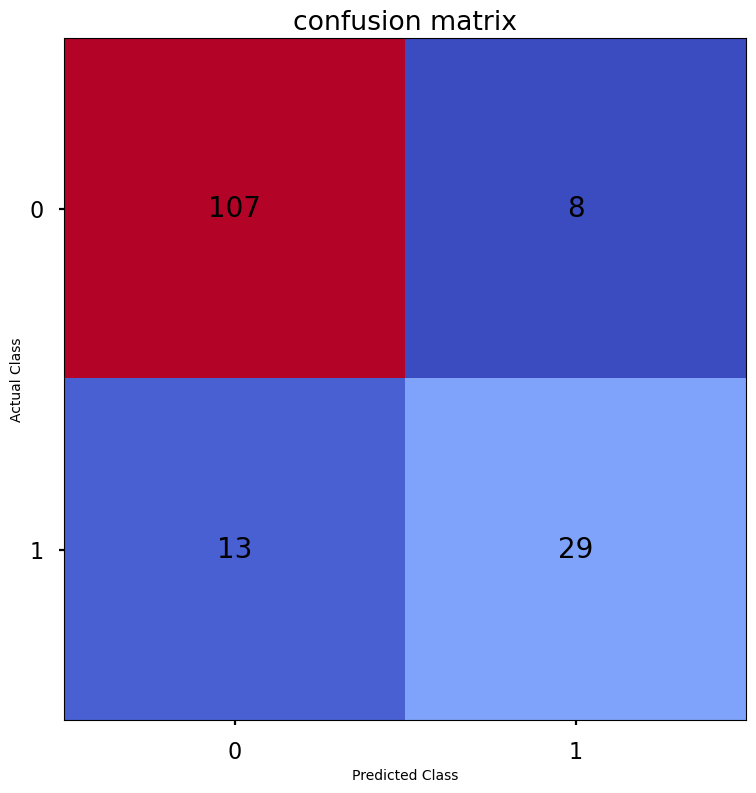

In [101]:
conf_matrix = confusion_matrix(y_test,y_pred_class)


import numpy as np
plt.style.use("seaborn-poster")
plt.matshow(conf_matrix, cmap="coolwarm")
plt.gca().xaxis.tick_bottom()
plt.title("confusion matrix")
plt.ylabel('Actual Class')
plt.xlabel("Predicted Class")

for (i,j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j,i,corr_value, ha="center", va="center", fontsize=20)
plt.show()


The aim is to have a high proportion of observations falling into the top left cell (predicted non-signup and actual non-signup) and the bottom right cell (predicted signup and actual signup).

Since the proportion of signups in our data was around 30:70 we will next analyse not only Classification Accuracy, but also Precision, Recall, and F1-Score which will help us assess how well our model has performed in reality.

In [102]:
print(accuracy_score(y_test,y_pred_class))

# accuracy = the number of correct classificiations out of all attempted classifications

0.8662420382165605


In [103]:
# precision = of all observations that they where predicted as signed, how many are actually signed
print(precision_score(y_test,y_pred_class))

0.7837837837837838


In [104]:
# Recall = of all the observations that where actually signed, how many of them we correctly predict as signed
print(recall_score(y_test,y_pred_class))

0.6904761904761905


In [105]:
# F1-Score = harmonic mean of precision & recall

print(f1_score(y_test,y_pred_class))

# since our data is slighly imbalanced , measuring f1-score rather than accuracy is probably
# a good idea

0.7341772151898734


In [106]:
pred_class = (y_pred_prob >= 0.01) * 1
pred_class

array([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0])

In [108]:
# Finding the optimum probability threshold

thresholds=np.arange(0,1,0.01)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    pred_class = (y_pred_prob >= threshold) * 1
    precision = precision_score(y_test, pred_class, zero_division=0)
    precision_scores.append(precision)
    recall = recall_score(y_test,pred_class)
    recall_scores.append(recall)
    f1 = f1_score(y_test,pred_class)
    f1_scores.append(f1)

    
f1_val=max(f1_scores)
print(f1_val)
f1_val_idx = f1_scores.index(f1_val)
print(f1_val_idx)

0.7804878048780488
44


/var/folders/bl/lpv4jfm17cd97_xfftsgr5240000gn/T/ipykernel_6318/2815678668.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-poster")


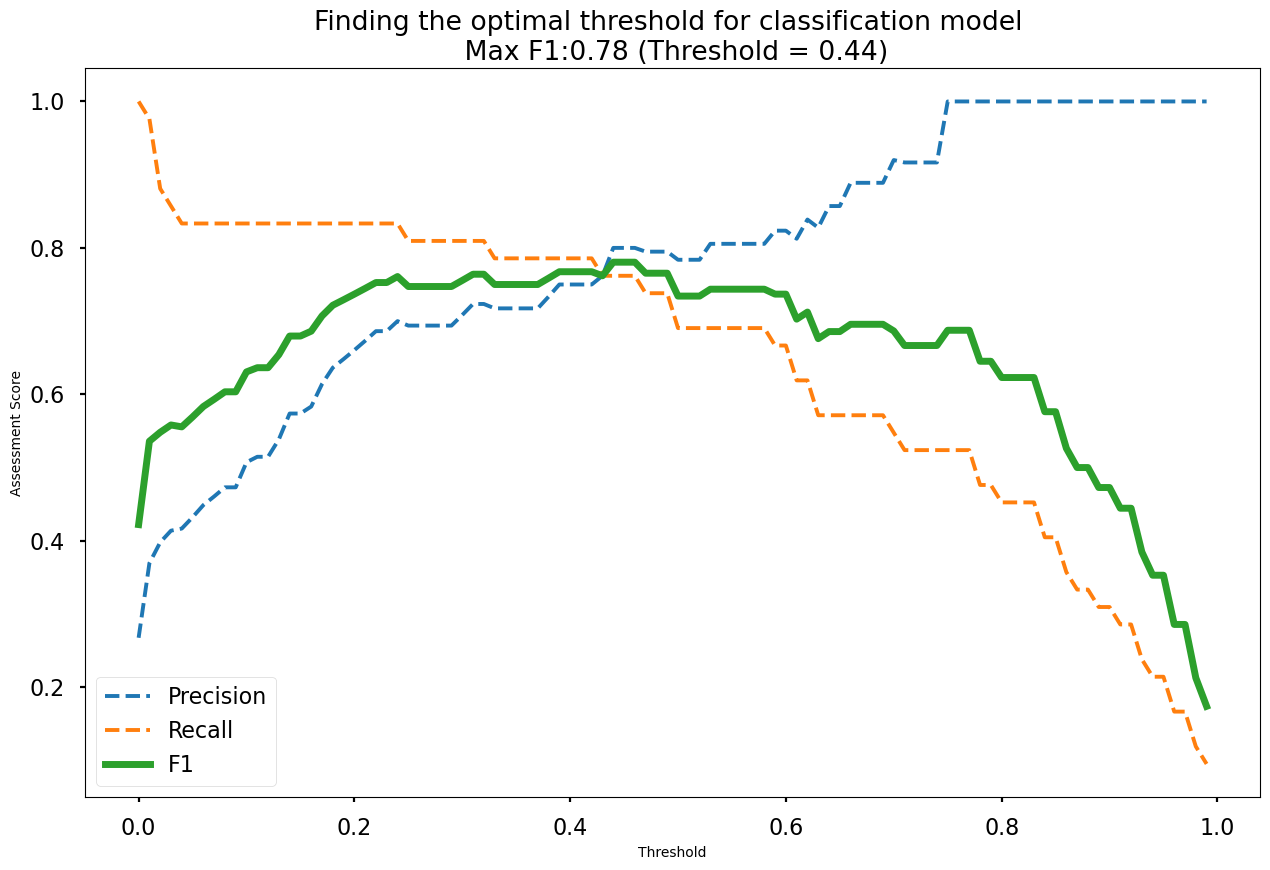

In [109]:
plt.style.use("seaborn-poster")
plt.plot(thresholds, precision_scores, label="Precision",linestyle='--')
plt.plot(thresholds, recall_scores, label="Recall", linestyle='--')
plt.plot(thresholds, f1_scores, label='F1', linewidth=5)
plt.title(f"Finding the optimal threshold for classification model \n Max F1:{round(f1_val,2)} (Threshold = {round(thresholds[f1_val_idx],2)})")
plt.xlabel("Threshold")
plt.ylabel("Assessment Score")
plt.legend(loc = "lower left")
plt.tight_layout()
plt.show()

Along the x-axis of the above plot we have the different classification thresholds that were testing. Along the y-axis we have the performance score for each of our three metrics. As per the legend, we have Precision as a blue dotted line, Recall as an orange dotted line, and F1-Score as a thick green line. You can see the interesting “zero-sum” relationship between Precision & Recall and you can see that the point where Precision & Recall meet is where F1-Score is maximised.

As you can see at the top of the plot, the optimal F1-Score for this model 0.78 and this is obtained at a classification threshold of 0.44. This is higher than the F1-Score of 0.734 that we achieved at the default classification threshold of 0.50!

In [110]:
optimal_threshold = 0.44
y_pred_class_opt_thresh = (y_pred_prob >= optimal_threshold) * 1
y_pred_class_opt_thresh

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0])

# Decision Tree
We will again utlise the scikit-learn library within Python to model our data using a Decision Tree. The code sections below are broken up into 6 key sections:

* Data Import
* Data Preprocessing
* Model Training
* Performance Assessment
* Tree Visualisation
* Decision Tree Regularisation

In [205]:
# import required packages
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

# import modelling data
data_for_model = pickle.load(open('/Users/praju/Desktop/DSI/Untitled Folder/ETA/abc_classification_modelling.p', "rb"))



In [206]:
data_for_model.head()

,customer_id,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,1,3.38,F,0.59,1586.89,195,26,5,61.034231
1,524,1,4.76,F,0.52,2397.26,258,27,5,88.787407
2,607,1,4.45,F,0.49,1279.91,183,22,5,58.177727
3,343,0,0.91,M,0.54,967.14,102,17,5,56.890588
4,322,1,3.02,F,0.63,1566.35,182,30,5,52.211667


In [207]:
data_for_model.drop('customer_id',axis=1,inplace=True)

In [208]:
data_for_model.shape

(860, 9)

In [209]:
# Shuffle Data

# if there are unknown order in data i.e sorted by customer number i.e sorted in longer term customer 
# to newer customers, this may or may not have the impact on the model and easy way to make sure it does'nt is to 
# always shuffle our data

data_for_model = shuffle(data_for_model, random_state=42)

In [210]:
data_for_model['signup_flag'].value_counts(normalize=True)

0    0.689535
1    0.310465
Name: signup_flag, dtype: float64

In [211]:
data_for_model.isna().sum()

signup_flag             0
distance_from_store     5
gender                  5
credit_score            8
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [212]:
data_for_model.dropna(how='any', inplace=True)

In [213]:
data_for_model.isna().sum()

signup_flag             0
distance_from_store     0
gender                  0
credit_score            0
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [214]:
data_for_model.isna().shape

(847, 9)

In [215]:
data_for_model.describe()

,signup_flag,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000
mean,0.304604,2.614545,0.597521,968.166411,143.877214,22.214876,4.177096,38.034161
std,0.460512,14.397590,0.102264,1073.647531,125.342694,11.721699,0.920887,24.243691
min,0.000000,0.000000,0.260000,2.090000,1.000000,1.000000,1.000000,2.090000
25%,0.000000,0.730000,0.530000,383.940000,77.000000,16.000000,4.000000,21.734700
50%,0.000000,1.640000,0.590000,691.640000,123.000000,23.000000,4.000000,31.069333
75%,1.000000,2.920000,0.670000,1121.530000,170.500000,28.000000,5.000000,46.429973
max,1.000000,400.970000,0.880000,7372.060000,910.000000,75.000000,5.000000,141.054091


In [216]:
data_for_model.shape

(847, 9)

In [217]:
# splitting input & output variable

X = data_for_model.drop('signup_flag',axis=1)
y = data_for_model['signup_flag']

In [218]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
# stratify = means our train and test set should have same proportions of classes as overall data

In [219]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(677, 8)
(170, 8)
(677,)
(170,)


In [220]:
# deal with categorical input variable

categorical_vars = ["gender"]

one_hot_encoder = OneHotEncoder(sparse=False,drop='first') # sparse = False means
# it will return an array rather than a sparse matrix
# meaning array will be easier to visualize
# remove dummy variable for multicollinearity by using drop = first

X_train_encoded=one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded=one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded,columns=encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True),X_train_encoded.reset_index(drop=True)],axis=1)
X_train.drop(categorical_vars,axis=1,inplace=True)

X_test_encoded = pd.DataFrame(X_test_encoded,columns=encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True),X_test_encoded.reset_index(drop=True)],axis=1)
X_test.drop(categorical_vars,axis=1,inplace=True)

# this is not so important in decision trees, but it would'nt added any more info
# so we remove the dummy variable


/Users/praju/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [221]:
X_train.head()

# In decision tree, each input variable is assessed individually and if
# there is no predictive power within an input variable, it will essentially just be ignored
# each time we asses which split is best, as it won't enhance the model anyway
# so running feature selection is not end of the world in Decision Tree model
# as in situations where we add many many input variables , it could help us to reduce down to
# a more managable number & from compution point of view , that could help us in efficiency
# but since we got only 8 input variables, that won't be a problem . so lets avoid Feature selection

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,1.22,0.60,636.51,123,22,5,28.932273,0.0
1,0.86,0.56,1141.28,112,21,5,54.346667,1.0
2,1.23,0.79,1207.42,210,26,4,46.439231,1.0
3,1.04,0.40,78.18,11,3,2,26.060000,1.0
4,0.07,0.62,740.51,94,24,5,30.854583,1.0


In [222]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier(random_state=42,max_depth=5)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [223]:
y_pred_class = clf.predict(X_test)

In [224]:
y_pred_prob = clf.predict_proba(X_test)[:,1] # prob that they signed for delivery club

/var/folders/bl/lpv4jfm17cd97_xfftsgr5240000gn/T/ipykernel_6318/1713925211.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-poster")


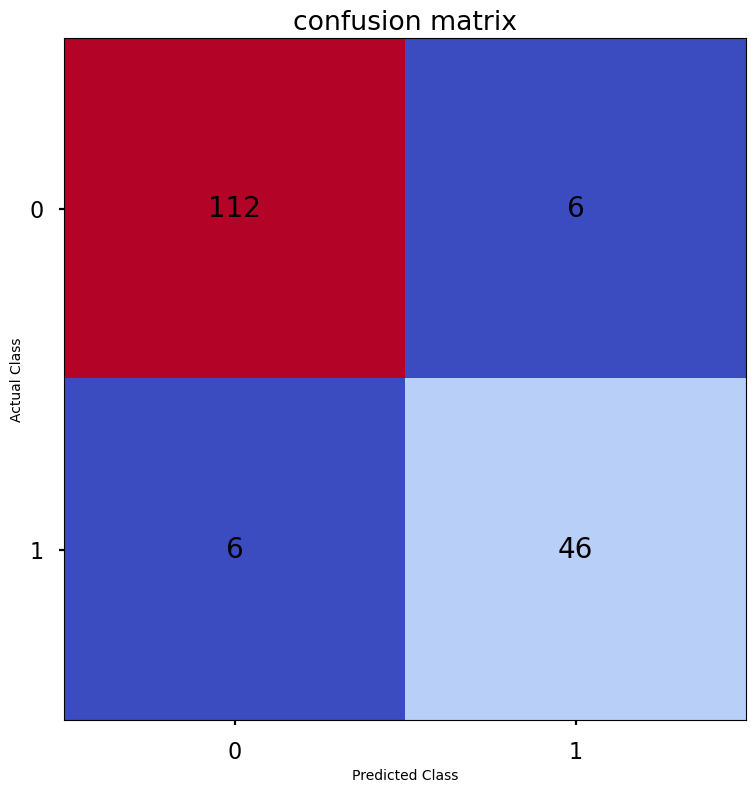

In [225]:
conf_matrix = confusion_matrix(y_test,y_pred_class)


import numpy as np
plt.style.use("seaborn-poster")
plt.matshow(conf_matrix, cmap="coolwarm")
plt.gca().xaxis.tick_bottom()
plt.title("confusion matrix")
plt.ylabel('Actual Class')
plt.xlabel("Predicted Class")

for (i,j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j,i,corr_value, ha="center", va="center", fontsize=20)
plt.show()


The aim is to have a high proportion of observations falling into the top left cell (predicted non-signup and actual non-signup) and the bottom right cell (predicted signup and actual signup).

Since the proportion of signups in our data was around 30:70 we will again analyse not only Classification Accuracy, but also Precision, Recall, and F1-Score as they will help us assess how well our model has performed from different points of view.

In [226]:
print(accuracy_score(y_test,y_pred_class))

# accuracy = the number of correct classificiations out of all attempted classifications

0.9294117647058824


In [227]:
# precision = of all observations that they where predicted as signed, how many are actually signed
print(precision_score(y_test,y_pred_class))

0.8846153846153846


In [228]:
# Recall = of all the observations that where actually signed, how many of them we correctly predict as signed
print(recall_score(y_test,y_pred_class))

0.8846153846153846


In [229]:
# F1-Score = harmonic mean of precision & recall

print(f1_score(y_test,y_pred_class))

# since our data is slighly imbalanced , measuring f1-score rather than accuracy is probably
# a good idea

0.8846153846153846


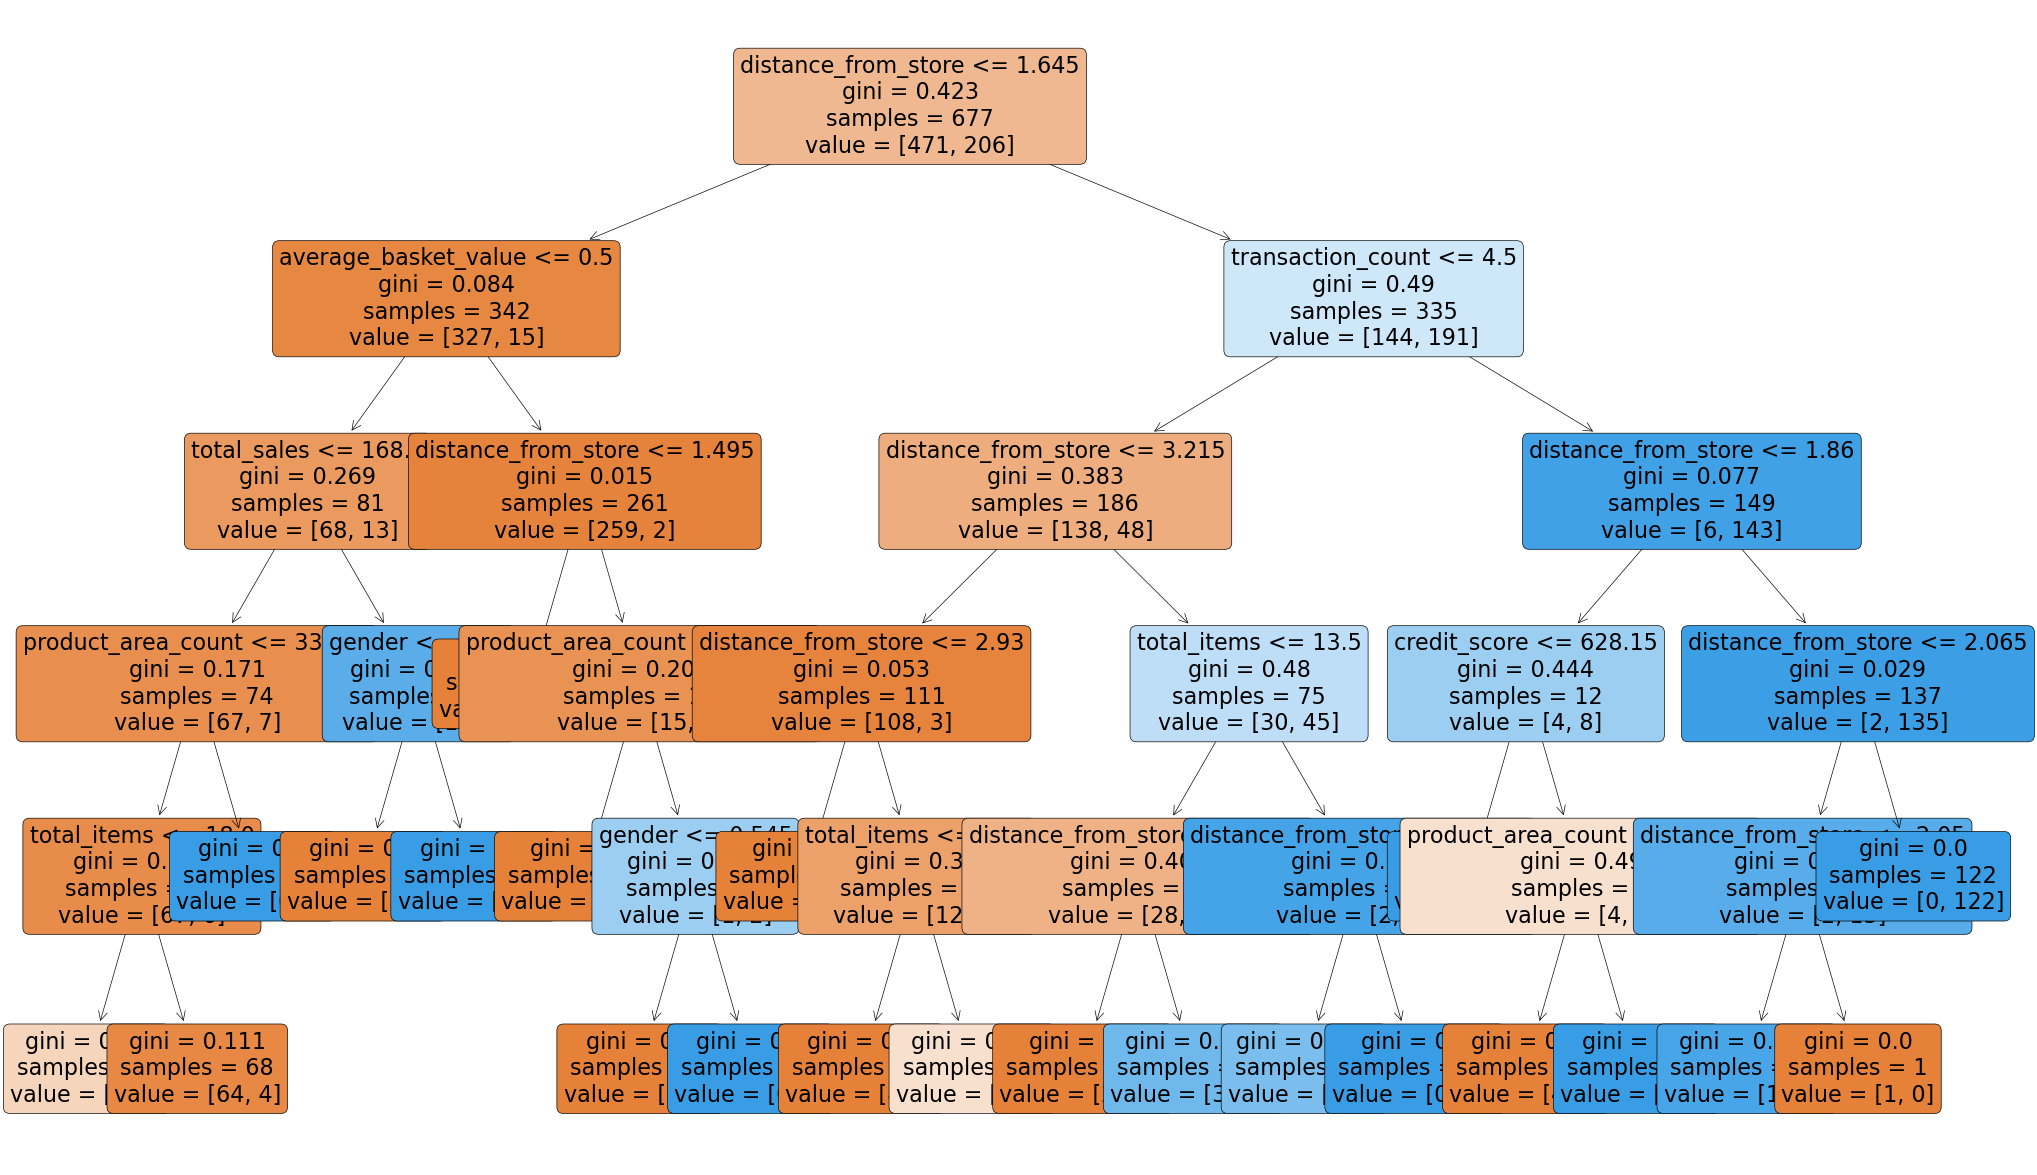

In [230]:
# plot the nodes of the decision tree
plt.figure(figsize=(25,15))
tree = plot_tree(clf,
                 feature_names = X.columns,
                 filled = True,
                 rounded = True,
                 fontsize = 16)

This is a very powerful visual, and one that can be shown to stakeholders in the business to ensure they understand exactly what is driving the predictions.

One interesting thing to note is that the very first split appears to be using the variable **distance from store** so it would seem that this is a very important variable when it comes to predicting signups to the delivery club!

In [231]:
max_depth_list = list(range(1,15))
accuracy_scores = []

for depth in max_depth_list:
    clf = DecisionTreeClassifier(max_depth=depth,random_state=42)
    clf.fit(X_train,y_train)
    
    y_pred=clf.predict(X_test)
    accuracy=f1_score(y_test,y_pred) # we do f1-score as data is not really well balanced
    accuracy_scores.append(accuracy)

print(accuracy_scores)


[0.6857142857142856, 0.7741935483870966, 0.8347826086956522, 0.7659574468085107, 0.8846153846153846, 0.9056603773584906, 0.9038461538461539, 0.8846153846153846, 0.9245283018867925, 0.8952380952380953, 0.8952380952380953, 0.8952380952380953, 0.8952380952380953, 0.8952380952380953]


In [232]:
max_accuracy=max(accuracy_scores)
max_accuracy_index=accuracy_scores.index(max_accuracy)
optimal_depth = max_depth_list[max_accuracy_index]

print(max_accuracy)
print(max_accuracy_index)
print(optimal_depth)

0.9245283018867925
8
9


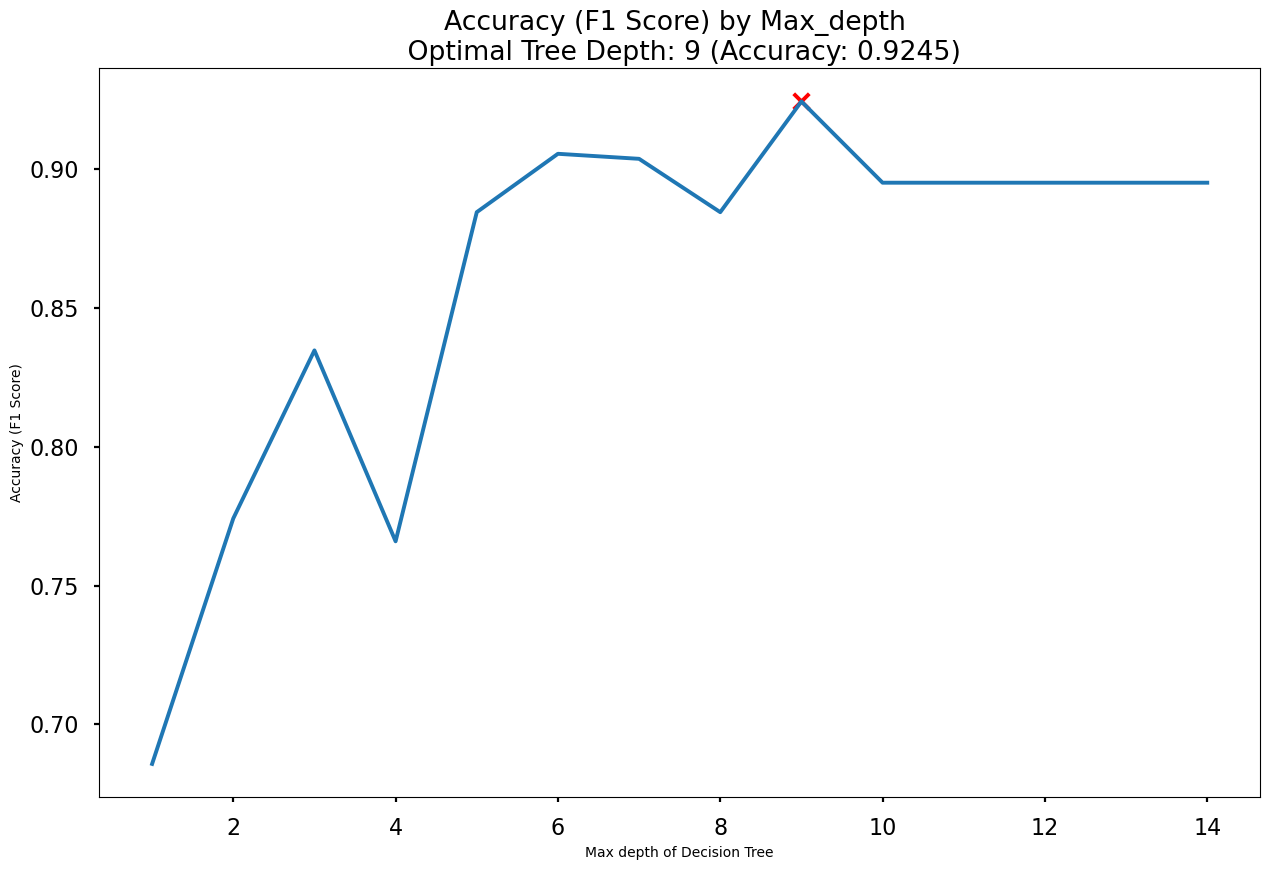

In [233]:
# plot of max_depths

plt.plot(max_depth_list,accuracy_scores)
plt.scatter(optimal_depth,max_accuracy,marker='x',color='red')
plt.title(f"Accuracy (F1 Score) by Max_depth \n Optimal Tree Depth: {optimal_depth} (Accuracy: {round(max_accuracy,4)})")
plt.xlabel("Max depth of Decision Tree")
plt.ylabel("Accuracy (F1 Score)")
plt.tight_layout()
plt.show()

In the plot we can see that the maximum F1-Score on the test set is found when applying a max_depth value of 9 which takes our F1-Score up to 0.925

# Random Forest
We will again utlise the scikit-learn library within Python to model our data using a Random Forest. The code sections below are broken up into 4 key sections:

* Data Import
* Data Preprocessing
* Model Training
* Performance Assessment

In [140]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix,accuracy_score,  precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance


# Random Forest is an ensemble model consist of many decision trees with different
# randomly selected subset of data which will gives us improved performance and accuracy
# all depends on 1) Random sample of data points 2) Random sample of input variables

# 1) Random sample of data points = this is done using boostrapping
# boostrapping is a sampling method which involves iteratively resampling data with
# replacement

# the predicted value is based on majority votes of the output from each tree


In [141]:
data_for_model = pickle.load(open('/Users/praju/Desktop/DSI/Untitled Folder/abc_classification_modelling.p', "rb"))

In [142]:
data_for_model.head()

,customer_id,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,1,3.38,F,0.59,1586.89,195,26,5,61.034231
1,524,1,4.76,F,0.52,2397.26,258,27,5,88.787407
2,607,1,4.45,F,0.49,1279.91,183,22,5,58.177727
3,343,0,0.91,M,0.54,967.14,102,17,5,56.890588
4,322,1,3.02,F,0.63,1566.35,182,30,5,52.211667


In [143]:
data_for_model.drop('customer_id',axis=1,inplace=True)

In [144]:
data_for_model.shape

(860, 9)

In [145]:
# Shuffle Data

# if there are unknown order in data i.e sorted by customer number i.e sorted in longer term customer 
# to newer customers, this may or may not have the impact on the model and easy way to make sure it does'nt is to 
# always shuffle our data

data_for_model = shuffle(data_for_model, random_state=42)

In [146]:
data_for_model['signup_flag'].value_counts(normalize=True)
# since it is not balaned well, we will look on precision, recall, f1-score etc

0    0.689535
1    0.310465
Name: signup_flag, dtype: float64

In [147]:
data_for_model.isna().sum()

signup_flag             0
distance_from_store     5
gender                  5
credit_score            8
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [148]:
data_for_model.dropna(how='any', inplace=True)

In [149]:
data_for_model.isna().sum()

signup_flag             0
distance_from_store     0
gender                  0
credit_score            0
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [150]:
data_for_model.isna().shape

(847, 9)

In [151]:
data_for_model.describe()

,signup_flag,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000
mean,0.304604,2.614545,0.597521,968.166411,143.877214,22.214876,4.177096,38.034161
std,0.460512,14.397590,0.102264,1073.647531,125.342694,11.721699,0.920887,24.243691
min,0.000000,0.000000,0.260000,2.090000,1.000000,1.000000,1.000000,2.090000
25%,0.000000,0.730000,0.530000,383.940000,77.000000,16.000000,4.000000,21.734700
50%,0.000000,1.640000,0.590000,691.640000,123.000000,23.000000,4.000000,31.069333
75%,1.000000,2.920000,0.670000,1121.530000,170.500000,28.000000,5.000000,46.429973
max,1.000000,400.970000,0.880000,7372.060000,910.000000,75.000000,5.000000,141.054091


In [152]:
data_for_model.shape

(847, 9)

In [153]:
# splitting input & output variable

X = data_for_model.drop('signup_flag',axis=1)
y = data_for_model['signup_flag']

In [154]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
# stratify = means our train and test set should have same proportions of classes as overall data

In [155]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(677, 8)
(170, 8)
(677,)
(170,)


In [157]:
# deal with categorical input variable

categorical_vars = ["gender"]

one_hot_encoder = OneHotEncoder(sparse=False,drop='first') # sparse = False means
# it will return an array rather than a sparse matrix
# meaning array will be easier to visualize
# remove dummy variable for multicollinearity by using drop = first

X_train_encoded=one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded=one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded,columns=encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True),X_train_encoded.reset_index(drop=True)],axis=1)
X_train.drop(categorical_vars,axis=1,inplace=True)

X_test_encoded = pd.DataFrame(X_test_encoded,columns=encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True),X_test_encoded.reset_index(drop=True)],axis=1)
X_test.drop(categorical_vars,axis=1,inplace=True)

# this is not so important in random forest, but it would'nt added any more info
# so we remove the dummy variable


/Users/praju/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [158]:
X_train.head()

# In decision tree, each input variable is assessed individually and if
# there is no predictive power within an input variable, it will essentially just be ignored
# each time we asses which split is best, as it won't enhance the model anyway
# so running feature selection is not end of the world in Decision Tree model
# as in situations where we add many many input variables , it could help us to reduce down to
# a more managable number & from compution point of view , that could help us in efficiency
# but since we got only 8 input variables, that won't be a problem . so lets avoid Feature selection

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,1.22,0.60,636.51,123,22,5,28.932273,0.0
1,0.86,0.56,1141.28,112,21,5,54.346667,1.0
2,1.23,0.79,1207.42,210,26,4,46.439231,1.0
3,1.04,0.40,78.18,11,3,2,26.060000,1.0
4,0.07,0.62,740.51,94,24,5,30.854583,1.0


In [159]:
clf = RandomForestClassifier(random_state=42, n_estimators=500, max_features=5)
clf.fit(X_train,y_train)

RandomForestClassifier(max_features=5, n_estimators=500, random_state=42)

In [160]:
y_pred_class = clf.predict(X_test)

# output is 0 or 1 with default 50% threshold
# This 50% threshold in random forest for classification, it is based on number of decision trees in random forest
# that came to the conclusion that data point was either in positive or negative class
# so for example if we run 100 trees in a forest & for a certain data point
# 70 trees predicted as positive and 30 predicted as negative , then that data point
# will be given probability of being in the positive class of 70% & prob of being
# in negative class of 30%

In [161]:
y_pred_prob = clf.predict_proba(X_test)[:,1] # prob that they signed for delivery club

/var/folders/bl/lpv4jfm17cd97_xfftsgr5240000gn/T/ipykernel_6318/1713925211.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-poster")


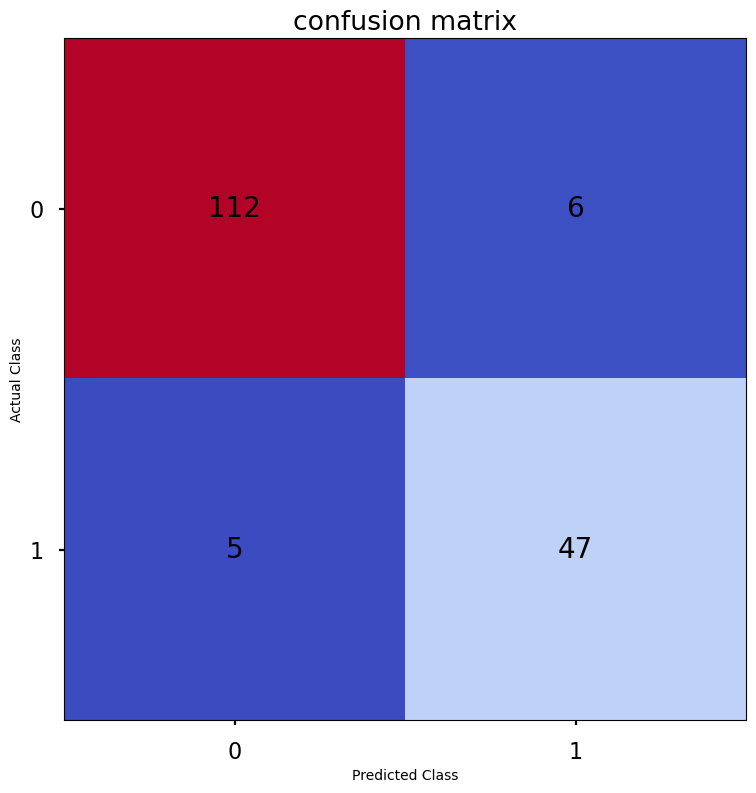

In [162]:
conf_matrix = confusion_matrix(y_test,y_pred_class)


import numpy as np
plt.style.use("seaborn-poster")
plt.matshow(conf_matrix, cmap="coolwarm")
plt.gca().xaxis.tick_bottom()
plt.title("confusion matrix")
plt.ylabel('Actual Class')
plt.xlabel("Predicted Class")

for (i,j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j,i,corr_value, ha="center", va="center", fontsize=20)
plt.show()


The aim is to have a high proportion of observations falling into the top left cell (predicted non-signup and actual non-signup) and the bottom right cell (predicted signup and actual signup).

Since the proportion of signups in our data was around 30:70 we will again analyse not only Classification Accuracy, but also Precision, Recall, and F1-Score as they will help us assess how well our model has performed from different points of view.

In [163]:
print(accuracy_score(y_test,y_pred_class))

# accuracy = the number of correct classificiations out of all attempted classifications

0.9352941176470588


In [164]:
# precision = of all observations that they where predicted as signed, how many are actually signed
print(precision_score(y_test,y_pred_class))

0.8867924528301887


In [165]:
# Recall = of all the observations that where actually signed, how many of them we correctly predict as signed
print(recall_score(y_test,y_pred_class))

0.9038461538461539


In [166]:
# F1-Score = harmonic mean of precision & recall

print(f1_score(y_test,y_pred_class))

# since our data is slighly imbalanced , measuring f1-score rather than accuracy is probably
# a good idea

0.8952380952380953


        input_variables  Feature_importance
1                gender            0.024698
3           total_sales            0.039331
7  average_basket_value            0.051438
4           total_items            0.057100
6    product_area_count            0.094937
2          credit_score            0.111444
5     transaction_count            0.153123
0   distance_from_store            0.467928


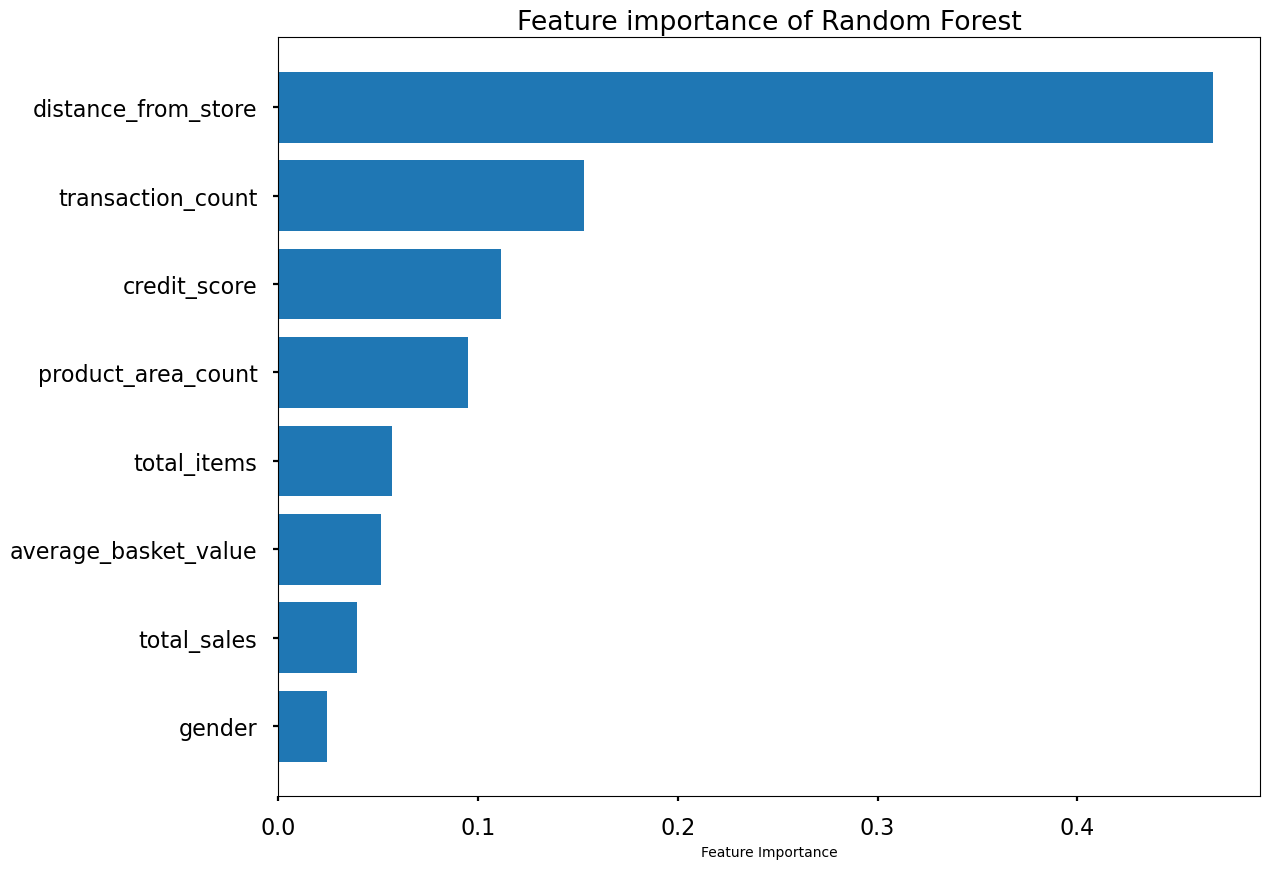

In [167]:
feature_importance = pd.DataFrame(clf.feature_importances_)
feature_names = pd.DataFrame(X.columns)
feature_importance_summary = pd.concat([feature_names,feature_importance],axis=1)
feature_importance_summary.columns=['input_variables','Feature_importance']
feature_importance_summary.sort_values(by='Feature_importance',inplace=True)
print(feature_importance_summary)

plt.barh(feature_importance_summary['input_variables'],feature_importance_summary['Feature_importance'])
plt.title('Feature importance of Random Forest')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [168]:
# Permutation Importance

# The permutation feature importance is seen as decrease in model performance/accuracy when a particular input
# variables are randomly shuffled
# randomly shuffled destroys any relationship would have with the output variable and thus
# gives us a way to understand its importance as we can compare model performance with the shuffling 
# and with the values in their normal state 

# A large decrease in model performance when shuffled would indicate this as an input variable
# with high level of importance to our predictions and this approach is often preferred
# over standard feature importance method that we used above that measures the improvement of mean squared error
# as this can sometimes inflate the importance of numerical features

# but both methods are useful and in most cases will give fairly similar results


result = permutation_importance(clf,X_test,y_test,n_repeats=10, random_state=42)
# n_repeat = specifies how many times we have to apply this random shuffling to each variable
print(result)

{'importances_mean': array([ 0.29764706, -0.00529412, -0.00058824, -0.00529412,  0.02941176,
        0.10941176,  0.00235294,  0.02294118]), 'importances_std': array([0.02685344, 0.00411765, 0.00850402, 0.00411765, 0.01366935,
       0.01294118, 0.00470588, 0.0080869 ]), 'importances': array([[ 0.33529412,  0.32352941,  0.31176471,  0.33529412,  0.26470588,
         0.3       ,  0.28823529,  0.25882353,  0.28823529,  0.27058824],
       [-0.00588235, -0.00588235, -0.01176471, -0.00588235,  0.        ,
         0.        , -0.00588235, -0.00588235,  0.        , -0.01176471],
       [-0.00588235, -0.01176471,  0.        ,  0.00588235,  0.        ,
        -0.01176471,  0.        ,  0.01764706,  0.00588235, -0.00588235],
       [ 0.        , -0.00588235,  0.        , -0.01176471,  0.        ,
        -0.00588235, -0.00588235, -0.00588235, -0.01176471, -0.00588235],
       [ 0.03529412,  0.00588235,  0.02941176,  0.03529412,  0.01176471,
         0.04705882,  0.02352941,  0.04705882,  0.04

        input_variables  permutation_importance
1                gender               -0.005294
3           total_sales               -0.005294
2          credit_score               -0.000588
6    product_area_count                0.002353
7  average_basket_value                0.022941
4           total_items                0.029412
5     transaction_count                0.109412
0   distance_from_store                0.297647


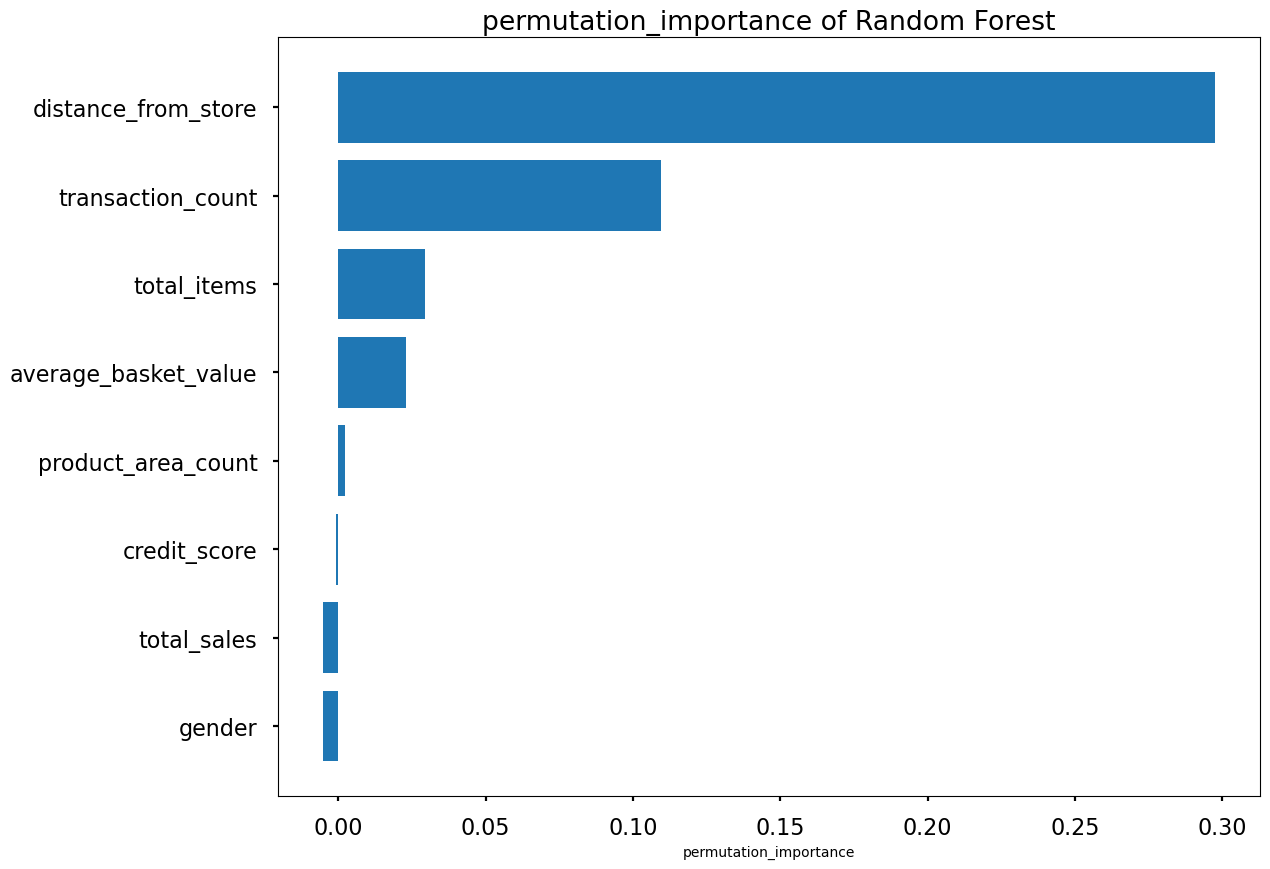

In [169]:
permutation_importance = pd.DataFrame(result["importances_mean"])
feature_names = pd.DataFrame(X.columns)
permutation_importance_summary = pd.concat([feature_names,permutation_importance],axis=1)
permutation_importance_summary.columns=['input_variables','permutation_importance']
permutation_importance_summary.sort_values(by='permutation_importance',inplace=True)
print(permutation_importance_summary)

plt.barh(permutation_importance_summary['input_variables'],permutation_importance_summary['permutation_importance'])
plt.title('permutation_importance of Random Forest')
plt.xlabel('permutation_importance')
plt.tight_layout()
plt.show()

The overall story from both approaches is very similar, in that by far, the most important or impactful input variables are distance_from_store and transaction_count

Surprisingly, average_basket_size was not as important as hypothesised.

There are slight differences in the order or “importance” for the remaining variables but overall they have provided similar findings.

# K Nearest Neighbours

We utlise the scikit-learn library within Python to model our data using KNN. The code sections below are broken up into 5 key sections:

* Data Import
* Data Preprocessing
* Model Training
* Performance Assessment
* Optimal Value For K

In [188]:
# KNN algorithm is used to predict the class of an uknown data point
# using the most popular class of a number of nearby known data points

# the number of nearby known data points used to form the prediction is denoted
# by K


from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [170]:
data_for_model = pickle.load(open('/Users/praju/Desktop/DSI/Untitled Folder/abc_classification_modelling.p', "rb"))

In [171]:
data_for_model.head()

,customer_id,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,1,3.38,F,0.59,1586.89,195,26,5,61.034231
1,524,1,4.76,F,0.52,2397.26,258,27,5,88.787407
2,607,1,4.45,F,0.49,1279.91,183,22,5,58.177727
3,343,0,0.91,M,0.54,967.14,102,17,5,56.890588
4,322,1,3.02,F,0.63,1566.35,182,30,5,52.211667


In [172]:
data_for_model.drop('customer_id',axis=1,inplace=True)

In [173]:
# Shuffle Data

# if there are unknown order in data i.e sorted by customer number i.e sorted in longer term customer 
# to newer customers, this may or may not have the impact on the model and easy way to make sure it does'nt is to 
# always shuffle our data

data_for_model = shuffle(data_for_model, random_state=42)

In [174]:
data_for_model['signup_flag'].value_counts(normalize=True)
# since it is not balaned well, we will look on precision, recall, f1-score etc

0    0.689535
1    0.310465
Name: signup_flag, dtype: float64

In [175]:
data_for_model.isna().sum()

signup_flag             0
distance_from_store     5
gender                  5
credit_score            8
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [176]:
data_for_model.dropna(how='any', inplace=True)

In [177]:
data_for_model.isna().shape

(847, 9)

In [178]:
data_for_model.describe()

,signup_flag,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000
mean,0.304604,2.614545,0.597521,968.166411,143.877214,22.214876,4.177096,38.034161
std,0.460512,14.397590,0.102264,1073.647531,125.342694,11.721699,0.920887,24.243691
min,0.000000,0.000000,0.260000,2.090000,1.000000,1.000000,1.000000,2.090000
25%,0.000000,0.730000,0.530000,383.940000,77.000000,16.000000,4.000000,21.734700
50%,0.000000,1.640000,0.590000,691.640000,123.000000,23.000000,4.000000,31.069333
75%,1.000000,2.920000,0.670000,1121.530000,170.500000,28.000000,5.000000,46.429973
max,1.000000,400.970000,0.880000,7372.060000,910.000000,75.000000,5.000000,141.054091


In [179]:
# Now KNN is distance based model, you could argue that if a data point is long way away
# then it will never be just selected as one of the neighbors
# but outliers could cause few issues for our model
# and mostly this will be when it comes to scaling our data which will do very soon
# we don't want variable to be super bunched up due to a single outlier value as this will make hard
# to compare their values to the other input variables so i always think its best to remove them

# like we discussed , in practice it would be worth investigating the effect of outliers on our model
# a little bit more what we are doing here 
outlier_columns = ['distance_from_store','total_sales','total_items']

for col in outlier_columns:
    lower_quartile = data_for_model[col].quantile(0.25)
    upper_quartile = data_for_model[col].quantile(0.75)
    iqr = upper_quartile - lower_quartile
    iqr_extended = iqr*2 # here i keep 2 instead of 1.5 , as i said i don't want to cut too many
    # outliers as it is worth investigating this lot more than what we done here
    # and i just don't wanna make naive assumption that there are outliers in our data
    # but i want to include the logic so we can see in action
    min_border = lower_quartile - iqr_extended
    max_border = upper_quartile + iqr_extended
    
    outliers = data_for_model[(data_for_model[col] < min_border)| (data_for_model[col] > max_border)].index
    
    outliers1 = data_for_model[(data_for_model[col] < min_border)| (data_for_model[col] > max_border)]
    
    print(f'{len(outliers)} outliers detected in column {col}')
    
    data_for_model.drop(outliers,inplace=True)

8 outliers detected in column distance_from_store
54 outliers detected in column total_sales
3 outliers detected in column total_items


In [180]:
data_for_model.shape

(782, 9)

In [181]:
# splitting input & output variable

X = data_for_model.drop('signup_flag',axis=1)
y = data_for_model['signup_flag']

In [182]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)
# stratify = means our train and test set should have same proportions of classes as overall data

In [183]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(625, 8)
(157, 8)
(625,)
(157,)


In [185]:
# deal with categorical input variable

categorical_vars = ["gender"]

one_hot_encoder = OneHotEncoder(sparse=False,drop='first') # sparse = False means
# it will return an array rather than a sparse matrix
# meaning array will be easier to visualize
# remove dummy variable for multicollinearity by using drop = first

X_train_encoded=one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded=one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded,columns=encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True),X_train_encoded.reset_index(drop=True)],axis=1)
X_train.drop(categorical_vars,axis=1,inplace=True)

X_test_encoded = pd.DataFrame(X_test_encoded,columns=encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True),X_test_encoded.reset_index(drop=True)],axis=1)
X_test.drop(categorical_vars,axis=1,inplace=True)


/Users/praju/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [186]:
X_train.head()

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,0.07,0.57,746.15,133,24,5,31.089583,1.0
1,0.20,0.57,585.46,128,32,4,18.295625,1.0
2,3.07,0.53,1151.24,226,35,5,32.892571,0.0
3,2.86,0.77,14.03,8,2,2,7.015000,0.0
4,0.52,0.52,656.48,121,16,3,41.030000,1.0


In [189]:
# we are using normalization(MinMaxScaler) instead of Standardization
# the reason i mentioned is normalizing mean all our data will exist between 0 and 1
# means it will be comparable to any other categorical variables that we have encoded as 1 and 0
# if we standardize we most likely end up mainly between -3 & +3 and this is what less comparitive to those
# encoded in categorical variables 


scale_minmax = MinMaxScaler()

X_train = pd.DataFrame(scale_minmax.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scale_minmax.transform(X_test),columns=X_test.columns)

# scaling rules are learned from training
# data & applied to all other data including our test set
# if we use fit_transform on any other data, it will learn the rules from other data instead of
# training data. Those rules will be slightly different, meaning we can't rely on our predictions to be
# consistent.


In [190]:
# In KNN, Feature Selection is not interesting topic
# the algorithm is measuring the distance between data points across all the 
# "Dimensions" where each dimension is one of our input variables
# the algorithm treats each input variable equally important, there is not
# a concept of feature importance
# so the spread of data within unimportant variable could have an effect on
# judging other data points as either "close" or "far"
# if we have lot of unimportant variables in our data, this could create a lot
# of noice for the algorithm to deal with and we'll just see poor classification accuracy
# without really knowing why, having a lot of input variables also means the algorithm has
# to process a lot more information when calculating distance between all of the points
# so any way to reduce noice is not important for computation as well
# in order to do this for kNN, we are going to apply again the cross validated recursive feature
# elimination but rather than passing a logistic regression line, we gonna use "RandomForest" to judge the
# importance as this performed better on the data.

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
feature_selector = RFECV(clf)

fit = feature_selector.fit(X_train,y_train)

optimal_feature_count = feature_selector.n_features_
print(f"optimal number of features: {optimal_feature_count}")


optimal number of features: 6


In [191]:

X_train = X_train.loc[:,feature_selector.get_support()]
X_test = X_test.loc[:,feature_selector.get_support()]

#total_items #credt score have been removed

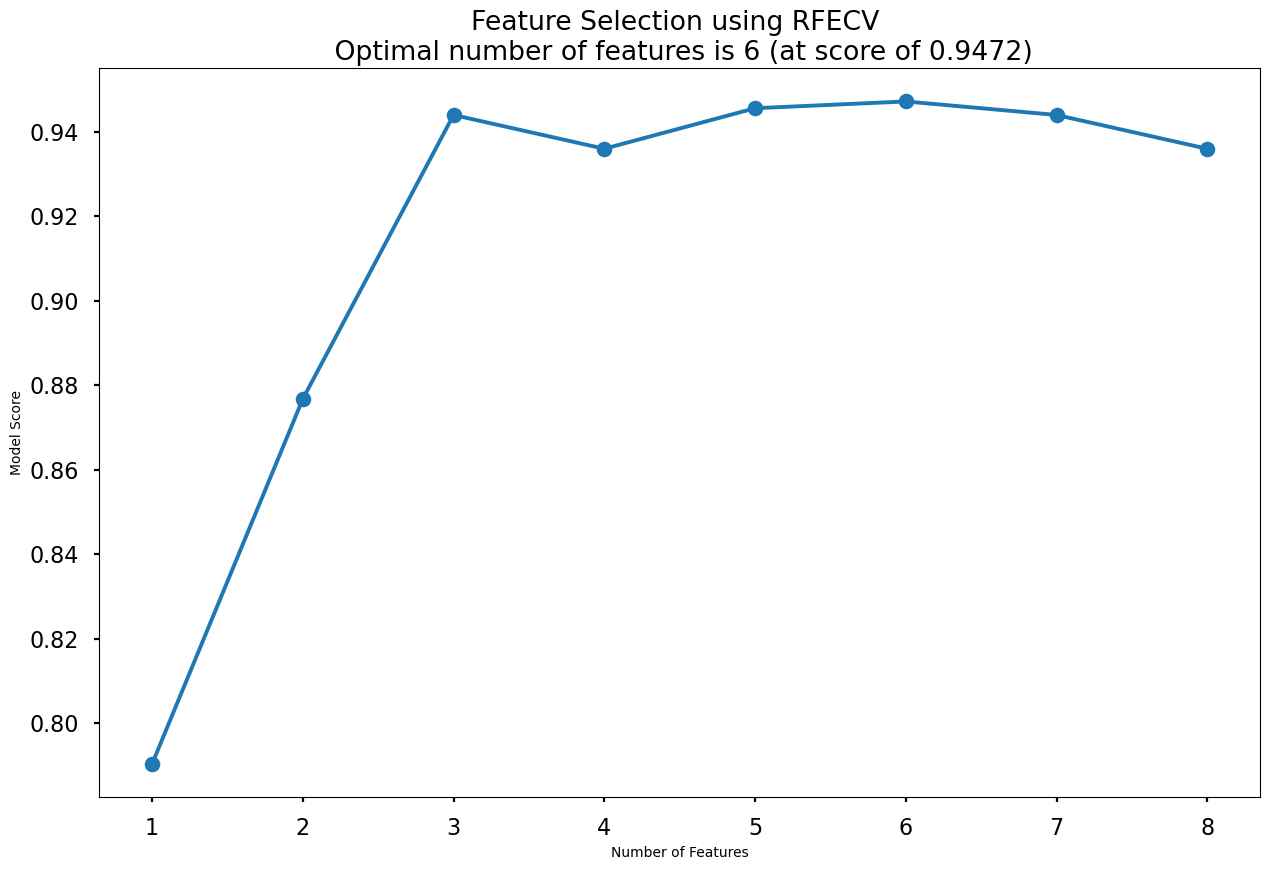

In [193]:


plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), fit.cv_results_['mean_test_score'], marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFECV \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.cv_results_['mean_test_score']),4)})")
plt.tight_layout()
plt.show()

In [194]:
clf = KNeighborsClassifier()
clf.fit(X_train,y_train)

# Kneighbors = number of data points used to denote the classification of 
# data points by default it is set to 5
# Weights = uniform ( all of neighbors where given equal weighting when deciding the
# classification)
# weights = distance ( where neighbors get higher weighting if they are slightly closer & 
# therefore have greater influence on the classification, by default set to "Uniform")

# the fact that p=2 and metric = "minkowski" means we are using the "Euclidean Distance"

KNeighborsClassifier()

In [195]:
y_pred_class = clf.predict(X_test) 

In [196]:
y_pred_proba = clf.predict_proba(X_test)[:,1]

/var/folders/bl/lpv4jfm17cd97_xfftsgr5240000gn/T/ipykernel_6318/1713925211.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-poster")


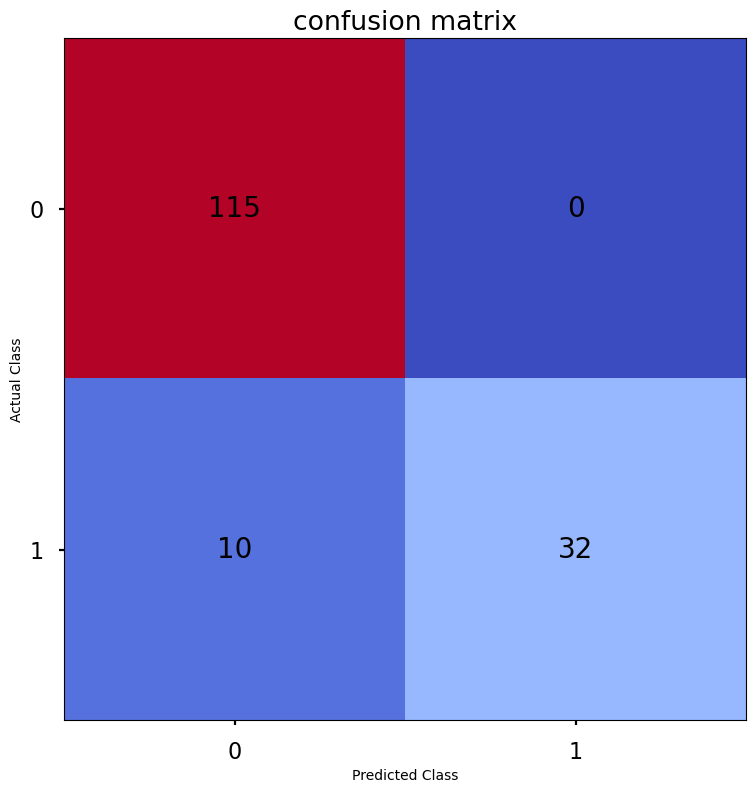

In [197]:
conf_matrix = confusion_matrix(y_test,y_pred_class)


import numpy as np
plt.style.use("seaborn-poster")
plt.matshow(conf_matrix, cmap="coolwarm")
plt.gca().xaxis.tick_bottom()
plt.title("confusion matrix")
plt.ylabel('Actual Class')
plt.xlabel("Predicted Class")

for (i,j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j,i,corr_value, ha="center", va="center", fontsize=20)
plt.show()


The aim is to have a high proportion of observations falling into the top left cell (predicted non-signup and actual non-signup) and the bottom right cell (predicted signup and actual signup).

The results here are interesting - all of the errors are where the model incorrectly classified delivery club signups as non-signups - the model made no errors when classifying non-signups non-signups.

Since the proportion of signups in our data was around 30:70 we will next analyse not only Classification Accuracy, but also Precision, Recall, and F1-Score which will help us assess how well our model has performed in reality.

In [198]:
print(accuracy_score(y_test,y_pred_class))

# accuracy = the number of correct classificiations out of all attempted classifications

0.9363057324840764


In [199]:
# precision = of all observations that they where predicted as signed, how many are actually signed
print(precision_score(y_test,y_pred_class))

1.0


In [200]:
# Recall = of all the observations that where actually signed, how many of them we correctly predict as signed
print(recall_score(y_test,y_pred_class))

0.7619047619047619


In [201]:
# F1-Score = harmonic mean of precision & recall

print(f1_score(y_test,y_pred_class))

# since our data is slighly imbalanced , measuring f1-score rather than accuracy is probably
# a good idea

0.8648648648648648


In [202]:
k_list = list(range(2,25))
accuracy_scores = []

for k in k_list:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train,y_train)
    
    y_pred=clf.predict(X_test)
    accuracy=f1_score(y_test,y_pred) # we do f1-score as data is not really well balanced
    accuracy_scores.append(accuracy)

print(accuracy_scores)


[0.8333333333333333, 0.8533333333333334, 0.8169014084507042, 0.8648648648648648, 0.8, 0.7887323943661971, 0.782608695652174, 0.782608695652174, 0.7647058823529412, 0.7647058823529412, 0.7647058823529412, 0.7647058823529412, 0.7462686567164178, 0.7462686567164178, 0.7076923076923077, 0.7462686567164178, 0.6875000000000001, 0.7076923076923077, 0.7076923076923077, 0.7076923076923077, 0.7076923076923077, 0.7076923076923077, 0.7076923076923077]


In [203]:
max_accuracy=max(accuracy_scores)
max_accuracy_index=accuracy_scores.index(max_accuracy)
optimal_k_value = k_list[max_accuracy_index]

print(max_accuracy)
print(max_accuracy_index)
print(optimal_k_value)

0.8648648648648648
3
5


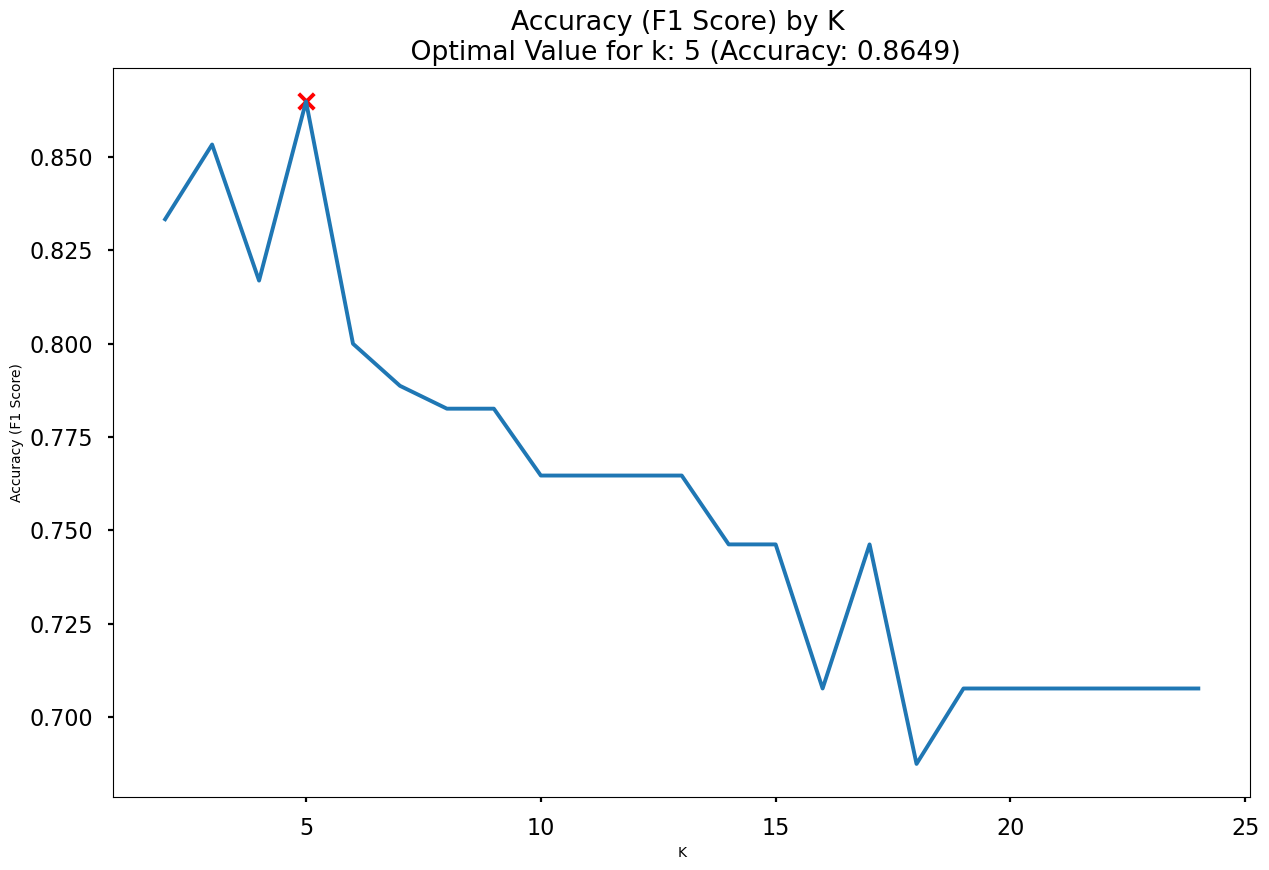

In [204]:
# plot of max_depths

plt.plot(k_list,accuracy_scores)
plt.scatter(optimal_k_value,max_accuracy,marker='x',color='red')
plt.title(f"Accuracy (F1 Score) by K \n Optimal Value for k: {optimal_k_value} (Accuracy: {round(max_accuracy,4)})")
plt.xlabel("K")
plt.ylabel("Accuracy (F1 Score)")
plt.tight_layout()
plt.show()

In the plot we can see that the maximum F1-Score on the test set is found when applying a k value of 5 - which is exactly what we started with, so nothing needs to change!

# Modelling Summary

The goal for the project was to build a model that would accurately predict the customers that would sign up for the delivery club. This would allow for a much more targeted approach when running the next iteration of the campaign. A secondary goal was to understand what the drivers for this are, so the client can get closer to the customers that need or want this service, and enhance their messaging.

Based upon these, **the chosen the model is the Random Forest as it was a) the most consistently performant on the test set across classication accuracy, precision, recall, and f1-score, and b) the feature importance and permutation importance allows the client an understanding of the key drivers behind delivery club signups**.


Metric 1: **Classification Accuracy**

KNN = 0.936
Random Forest = 0.935
Decision Tree = 0.929
Logistic Regression = 0.866

Metric 2: **Precision**

KNN = 1.00
Random Forest = 0.887
Decision Tree = 0.885
Logistic Regression = 0.784

Metric 3: **Recall**

Random Forest = 0.904
Decision Tree = 0.885
KNN = 0.762
Logistic Regression = 0.69

Metric 4: **F1 Score**

Random Forest = 0.895
Decision Tree = 0.885
KNN = 0.865
Logistic Regression = 0.734


We now have a model object, and a the required pre-processing steps to use this model for the next delivery club campaign. When this is ready to launch we can aggregate the neccessary customer information and pass it through, obtaining predicted probabilities for each customer signing up.

Based upon this, we can work with the client to discuss where their budget can stretch to, and contact only the customers with a high propensity to join. This will drastically reduce marketing costs, and result in a much improved ROI.